# Predictive Analysis With Auto ARIMA 

## Data Collection and Preprocessing

In [1]:
# Imports
import sys
import os
from datetime import datetime
from datetime import date
import pandas as pd
import numpy as np
import plotly
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as pyo
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX 
# To import the main.py file
sys.path.append('../')
from python_files import main
import warnings
warnings.filterwarnings("ignore")

# Getting all the data
confirmed_global, deaths_global, recovered_global, country_cases = main.collect_data()
rec = recovered_global.groupby("country").sum().T
death=deaths_global.groupby("country").sum().T
conf=confirmed_global.groupby("country").sum().T
death.index = pd.to_datetime(death.index, infer_datetime_format = True)
rec.index=pd.to_datetime(rec.index, infer_datetime_format=True)
conf.index=pd.to_datetime(conf.index, infer_datetime_format=True)

In [2]:
# Setting up plotly to work offline and in jupyter notebooks
pyo.init_notebook_mode(connected = True)
%matplotlib inline

In [3]:
def create_data_frame(Type):
    if Type=='Death':
        # Creating a dataframe with Total number of cases everyday in a column
        data = pd.DataFrame(index = death.index, data = death["US"].values, columns = ["Total"])
    elif Type=='Recovery':
        # Creating a dataframe with Total number of cases everyday in a column
        data = pd.DataFrame(index = rec.index, data = rec["US"].values, columns = ["Total"])
    elif Type=='Confirmed':
         # Creating a dataframe with Total number of cases everyday in a column
        data = pd.DataFrame(index = conf.index, data = conf["US"].values, columns = ["Total"])
    data['Date'] = data.index
    # Setting Date column as index
    data=data.set_index('Date', drop=True)
    # Making sure no zeroes exist in dataframe
    data = data[(data != 0).all(1)]
    return data


In [4]:
# Plotting the Data
def plot_data_frame():
    return px.line(data, template = 'plotly_dark')

In [5]:
def find_params():
    stepwise_model = auto_arima(train, start_p = 1, start_q = 1,
                               max_p = 3, max_q = 3, m = 52,
                               start_P = 0, seasonal = True,
                               d = None, D = 1, trace = True,
                               error_action = 'ignore',  
                               suppress_warnings = True, 
                               stepwise = True)
    return stepwise_model
    # Finding the pest p,d,q parametes for the model

In [6]:
def split_dataframe():
    # Setting a Split date for test and train datasets
    train, test = train_test_split(data, test_size=15, shuffle=False)
    print('Test shape:',test.shape)
    print('Train shape:',train.shape)
    print(f'Min date from train set: {train.index.min().date()}')
    print(f'Max date from train set:{train.index.max().date()}')
    print(f'Min date from test set: {test.index.min().date()}')
    print(f'Max date from test set: {test.index.max().date()}')
    return train,test

In [7]:
def Predict():
    # Fitting the model with train dataset
    stepwise_model.fit(train)
    # Forecasting
    pred = stepwise_model.predict(n_periods=len(test))
    # This returns an array of predictions:
#     print(pred)
    pred = pd.DataFrame(pred,index = test.index,columns=['Prediction'])
    # Plotting the predicted values and actual values
    return px.line(pd.concat([data,pred],axis=1), template = 'plotly_dark'),pred

In [8]:
def Future(order,seasonal_order):
    # Train the model on the full dataset 
    model = SARIMAX(data['Total'],  
                        order = order,  
                        seasonal_order = seasonal_order) 
    result = model.fit() 
  
    forecast = result.predict(start = len(data),  
                          end = (len(data)-1) + 14).rename('Forecast') 
    return px.line(pd.concat([data,forecast],axis=1), template = 'plotly_dark')



In [9]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## Recovery

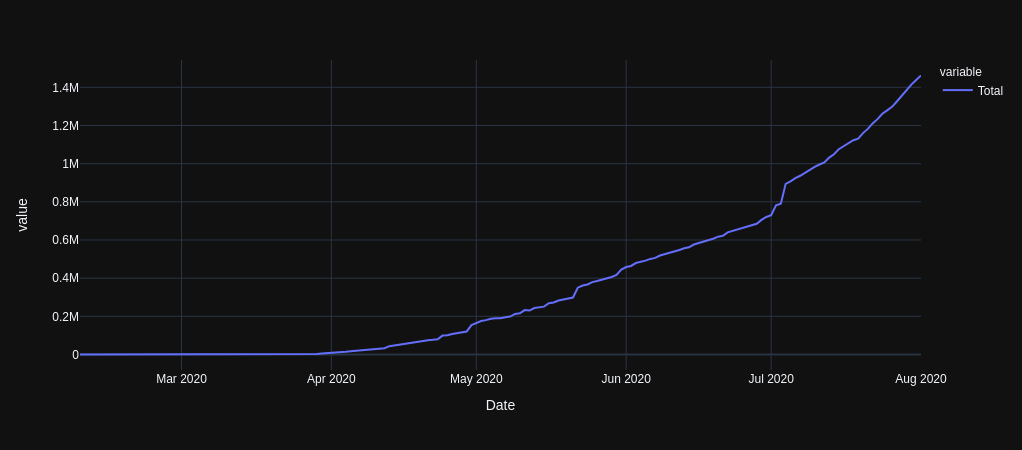

In [10]:
data=create_data_frame('Recovery')
plot_data_frame()

In [11]:
train,test=split_dataframe()
stepwise_model=find_params()
# print(stepwise_model.aic())
# print(stepwise_model.summary())

Test shape: (15, 1)
Train shape: (160, 1)
Min date from train set: 2020-02-09
Max date from train set:2020-07-17
Min date from test set: 2020-07-18
Max date from test set: 2020-08-01
Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,1,1,52) [intercept=True]; AIC=2319.994, BIC=2333.358, Time=8.235 seconds
Fit ARIMA(0,1,0)x(0,1,0,52) [intercept=True]; AIC=2320.172, BIC=2325.518, Time=0.408 seconds
Fit ARIMA(1,1,0)x(1,1,0,52) [intercept=True]; AIC=2319.016, BIC=2329.707, Time=5.588 seconds
Fit ARIMA(0,1,1)x(0,1,1,52) [intercept=True]; AIC=2319.965, BIC=2330.656, Time=4.894 seconds
Fit ARIMA(0,1,0)x(0,1,0,52) [intercept=False]; AIC=2347.199, BIC=2349.872, Time=0.729 seconds
Fit ARIMA(1,1,0)x(0,1,0,52) [intercept=True]; AIC=2322.120, BIC=2330.139, Time=0.335 seconds
Fit ARIMA(1,1,0)x(2,1,0,52) [intercept=True]; AIC=2320.996, BIC=2334.360, Time=16.132 seconds
Fit ARIMA(1,1,0)x(1,1,1,52) [intercept=True]; AIC=2319.713, BIC=2333.077, Time=8.395 seconds
Fit ARIMA(1,1,0)x(0,1,1,52) 

In [12]:
order=stepwise_model.get_params()['order']
seasonal_order=stepwise_model.get_params()['seasonal_order']

In [13]:
# prepare Fourier terms
fig,pred=Predict()
fig

In [14]:
mean_absolute_percentage_error(test,pred)

2.785844413156702

In [15]:
pred['Actual']=test.Total
pred

,Prediction,Actual
Date,,
2020-07-18,1.122127e+06,1122720
2020-07-19,1.138139e+06,1131121
2020-07-20,1.152823e+06,1160087
2020-07-21,1.169771e+06,1182018
2020-07-22,1.198802e+06,1210849
2020-07-23,1.218390e+06,1233269
2020-07-24,1.232602e+06,1261624
2020-07-25,1.253081e+06,1279414
2020-07-26,1.269171e+06,1297863


In [16]:
Future(order, seasonal_order)

## Deaths

In [17]:
data=create_data_frame('Death')
plot_data_frame()

In [ ]:
train,test=split_dataframe()
stepwise_model=find_params()
order=stepwise_model.get_params()['order']
seasonal_order=stepwise_model.get_params()['seasonal_order']

Test shape: (15, 1)
Train shape: (140, 1)
Min date from train set: 2020-02-29
Max date from train set:2020-07-17
Min date from test set: 2020-07-18
Max date from test set: 2020-08-01
Performing stepwise search to minimize aic
Fit ARIMA(1,2,1)x(0,1,1,52) [intercept=True]; AIC=1319.254, BIC=1331.526, Time=38.083 seconds
Fit ARIMA(0,2,0)x(0,1,0,52) [intercept=True]; AIC=1344.744, BIC=1349.652, Time=0.213 seconds
Fit ARIMA(1,2,0)x(1,1,0,52) [intercept=True]; AIC=1323.306, BIC=1333.123, Time=10.740 seconds
Near non-invertible roots for order (1, 2, 0)(1, 1, 0, 52); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.994)
Fit ARIMA(0,2,1)x(0,1,1,52) [intercept=True]; AIC=1326.637, BIC=1336.454, Time=17.104 seconds
Near non-invertible roots for order (0, 2, 1)(0, 1, 1, 52); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(0,2,0)x(0,1,0,52) [intercept=False]; AIC=1342.902, BIC=1345.356, Time=0

In [ ]:
fig,pred=Predict()
fig

In [ ]:
mean_absolute_percentage_error(test,pred)

In [ ]:
pred['Actual']=test.Total
pred

In [ ]:
Future(order, seasonal_order)

## Confirmed

In [ ]:
data=create_data_frame('Confirmed')
plot_data_frame()

In [ ]:
train,test=split_dataframe()
stepwise_model=find_params()
order=stepwise_model.get_params()['order']
seasonal_order=stepwise_model.get_params()['seasonal_order']

In [ ]:
fig,pred=Predict()
fig

In [ ]:
mean_absolute_percentage_error(test,pred)

In [ ]:
pred['Actual']=test.Total
pred

In [ ]:
Future(order, seasonal_order)